In [26]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

In [27]:
def set_ticks(ax, xMaj, xMin, yMaj, yMin):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.xaxis.set_minor_locator(AutoMinorLocator(xMin))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.yaxis.set_minor_locator(AutoMinorLocator(yMin))
    ax.tick_params(which='major', width=1.0, length=10, direction="in", labelsize=12)
    ax.tick_params(which='minor', width=1.0, length=5, direction="in", labelsize=12)

1\. PCA on 3D dataset

* Generate a dataset simulating 3 features, each with N entries (N being ${\cal O}(1000)$). Each feature is made by random numbers generated according the normal distribution $N(\mu,\sigma)$ with mean $\mu_i$ and standard deviation $\sigma_i$, with $i=1, 2, 3$. Generate the 3 variables $x_{i}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues using the eigendecomposition of the covariance matrix
* Find the eigenvectors and eigenvalues using the SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained
* Redefine the data according to the new basis from the PCA
* Plot the data, in both the original and the new basis. The figure should have 2 rows (the original and the new basis) and 3 columns (the $[x_0, x_1]$, $[x_0, x_2]$ and $[x_1, x_2]$ projections) of scatter plots.

In [28]:
# generate dataset
N = 1000
x1 = np.random.normal(0, 1, N)
x2 = np.random.normal(0, 3, N) + x1
x3 = 2 * x1 + x2
data = np.array([x1, x2, x3])

# get covariance
cov = np.cov(data)
print("The covariance matrix is:\n", cov)

'''
    Eigendecomposition.
'''

# get eigenvalues and eigenvectors
egl, egv = la.eig(cov)

# sort them in order to match the latter SVD 
index = np.argsort(egl)[::-1]
egl = egl[index]
egv = egv[:, index]
egl_real = np.real_if_close(egl)
print("\nEIGENDECOMPOSITION:")
print("-Eigenvalues:\n", egl, "->", egl_real)
print("-Eigenvectors:\n", egv)

'''
    Perform the eigendecomposition using the SVD.
    The third eigenvalue is sensibly different. If one uses
    the np.allclose() method with a high precision of the 
    orderd o(1.e-20), the eingevalues are in fact different.
'''

# perform the Single Value Decomposition
U, S, V = la.svd(data)
egl_svd = S**2 / (N - 1)
egv_svd = U
print("\nEIGENDECOMPOSITION USING SVD:")
print("-Eigenvalues:\n", egl_svd)
print("-Eigenvectors:\n", egv_svd, "\n")

# check
check = np.allclose(egl, egl_svd, 1.e-2)
if check:
    print("The two procedures approximately yield the same eigenvalues.")
check_egv = np.allclose(egv, egv_svd, 1.e-2)
if check_egv:
    print("The two procedures approximately yield the same eigenvectors.")

The covariance matrix is:
 [[ 1.00288215  1.32055876  3.32632306]
 [ 1.32055876 10.63623406 13.27735158]
 [ 3.32632306 13.27735158 19.9299977 ]]

EIGENDECOMPOSITION:
-Eigenvalues:
 [ 2.97707700e+01+0.j  1.79834392e+00+0.j -1.04900568e-15+0.j] -> [ 2.97707700e+01  1.79834392e+00 -1.04900568e-15]
-Eigenvectors:
 [[-0.12009399  0.56472185 -0.81649658]
 [-0.5715462  -0.71180635 -0.40824829]
 [-0.81173418  0.41763735  0.40824829]]

EIGENDECOMPOSITION USING SVD:
-Eigenvalues:
 [2.97708743e+01 1.80259820e+00 4.91151660e-31]
-Eigenvectors:
 [[-0.12010744  0.56471899 -0.81649658]
 [-0.57152925 -0.71181996 -0.40824829]
 [-0.81174412  0.41761802  0.40824829]] 

The two procedures approximately yield the same eigenvalues.
The two procedures approximately yield the same eigenvectors.


In [29]:
'''
    Principal Component Analysis (PCA) via dimension
    reduction. We begin with p = 3 features, hence the
    dimensionality
'''

# get lambda matrix
Lambda = np.diag(egl_real)

# select components
components = (0, 1, 2, (0, 1), (0, 2), (1, 2))

# compute variability for each component
variability = (abs(Lambda[0,0])/Lambda.trace(), abs(Lambda[1,1])/Lambda.trace(),
               abs(Lambda[2,2])/Lambda.trace(), abs(Lambda[0,0]+Lambda[1,1])/Lambda.trace(),
               abs(Lambda[0,0]+Lambda[2,2])/Lambda.trace(), abs(Lambda[0,0]+Lambda[2,2])/Lambda.trace())

for i, j in zip(components, variability):
    var = j * 100
    print("By selecting the component", i, "we retain {:.5f}% of the total variability.".format(var))
    if(var > 99):
        print("->The component", i, "retains at least 99% of the total variability.")

By selecting the component 0 we retain 94.30347% of the total variability.
By selecting the component 1 we retain 5.69653% of the total variability.
By selecting the component 2 we retain 0.00000% of the total variability.
By selecting the component (0, 1) we retain 100.00000% of the total variability.
->The component (0, 1) retains at least 99% of the total variability.
By selecting the component (0, 2) we retain 94.30347% of the total variability.
By selecting the component (1, 2) we retain 94.30347% of the total variability.


In [30]:
'''
    The features 0 and 1 are responsible for nearly 100% of 
    the variability. We only need 2 features to retain at 
    least 99% of the total variability.
    We can now rotate the dataset.
'''

# rotate dataset
rotated_data = np.dot(egv.T, data)     
#rotated_dataset

# reduce dataset
reduced_data = np.delete(rotated_data, np.argmin(egl_real), 0) 
#reduced_dataset

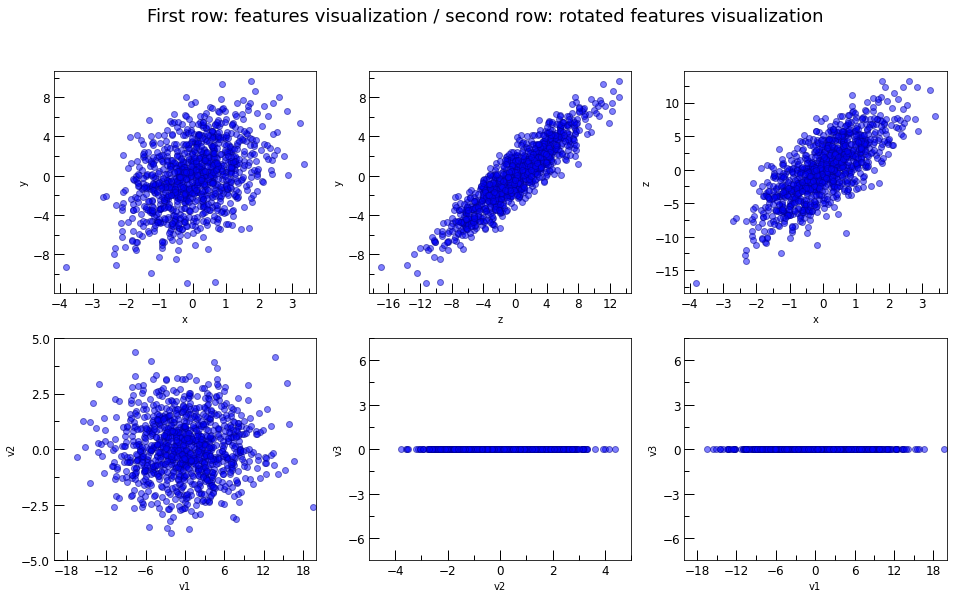

In [31]:
'''
    Visualize the features.
'''

# plot layout
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2, figsize = (16,9))
fig.suptitle("First row: features visualization / second row: rotated features visualization", fontsize=18)

# 0-1 scatter plot
set_ticks(ax1, 1, 2, 4, 2)
ax1.scatter(data[0], data[1], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
    
# 1-2 scatter plot
set_ticks(ax2, 4, 2, 4, 2)
ax2.scatter(data[2], data[1], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax2.set_xlabel("z")
ax2.set_ylabel("y")

# 0-1 scatter plot
set_ticks(ax3, 1, 2, 5, 2)
ax3.scatter(data[0], data[2], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax3.set_xlabel("x")
ax3.set_ylabel("z")

'''
    Second row: rotated features.
'''

# limits
lim_v1 = (-20, 20)
lim_v2 = (-5, 5)
lim_v3 = (-7.5, 7.5)

# 0-1 scatter plot
set_ticks(ax4, 6, 2, 2.5, 2)
ax4.scatter(rotated_data[0], rotated_data[1], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax4.set_xlabel("v1")
ax4.set_ylabel("v2")
ax4.set_xlim(lim_v1)
ax4.set_ylim(lim_v2)
    
# 1-2 scatter plot
set_ticks(ax5, 2, 2, 3, 2)
ax5.scatter(rotated_data[1], rotated_data[2], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax5.set_xlabel("v2")
ax5.set_ylabel("v3")
ax5.set_xlim(lim_v2)
ax5.set_ylim(lim_v3)

# 0-1 scatter plot
set_ticks(ax6, 6, 2, 3, 2)
ax6.scatter(rotated_data[0], rotated_data[2], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax6.set_xlabel("v1")
ax6.set_ylabel("v3")
ax6.set_xlim(lim_v1)
ax6.set_ylim(lim_v3)

plt.show()

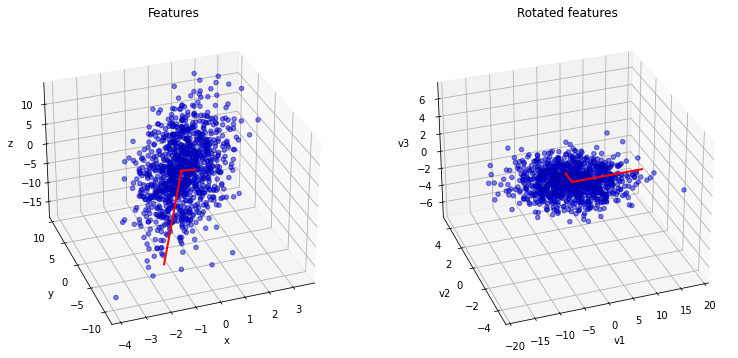

In [32]:
# plot layout
fig = plt.figure(figsize=(20,10))

# 3D visualization - raw features
ax1 = plt.subplot2grid((1, 3), (0, 1), rowspan=1, colspan=1, projection='3d')
ax1.scatter(data[0], data[1], data[2], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)

for l, v in zip(egl_real, egv.T):
    ax1.plot([0, .5*l*v[0]], [0, .5*l*v[1]], [0, .5*l*v[2]], 'r-', lw=2, zorder=10)
    
ax1.view_init(elev = 30, azim = 250)
ax1.set_title("Features")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

# 3D visualization - rotated features
ax2 = plt.subplot2grid((1, 3), (0, 2), rowspan=1, colspan=1, projection='3d')
ax2.scatter(rotated_data[0], rotated_data[1], rotated_data[2], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)

for l, v in zip(egl_real, np.diag([1]*3)):
    ax2.plot([0, .5*l*v[0]], [0, .5*l*v[1]], [0, .5*l*v[2]], 'r-', lw=2, zorder=10)
    
ax2.view_init(elev = 30, azim = 250)
ax2.set_title("Rotated features")
ax2.set_xlabel("v1")
ax2.set_ylabel("v2")
ax2.set_zlabel("v3")
ax2.set_xlim(lim_v1)
ax2.set_ylim(lim_v2)
ax2.set_zlim(lim_v3)

plt.show()

2\. PCA on a nD dataset

* Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normally distributed, with a standard deviation much smaller (e.g. a factor 20) than those used to generate the $x_1$ and $x_2$. Repeat the PCA procedure and compare the results with what you have obtained before.

In [33]:
'''
    It is possible to see that we found the same
    principal components as in the previous exercise.
    The additional random noise feature has a negligible
    variablity.
'''

# generate noise
noise = []
for i in range(10):
    noise.append(np.random.normal(0, 1/50, N))

# add noise to original dataset
data_n = np.concatenate((data, np.array(noise)))

# covariance matrix
cov_n = np.cov(data_n)

# eigendecomposition
egl_n, egv_n = la.eig(cov_n)

# PCA
Lambda_n = np.diag(np.real_if_close(egl_n))
#print(np.real_if_close(egl_n) / np.trace(Lambda_n))

# results
var = abs(Lambda_n[0,0] + Lambda_n[1,1]) / Lambda_n.trace()
print("Obtained k = 2 and selecting components (0, 1) we retain", var*100,
      "of the total variability.")

Obtained k = 2 and selecting components (0, 1) we retain 99.98775264053992 of the total variability.


3\. **Optional**: PCA on the MAGIC dataset

Perform a PCA on the magic04.data dataset.

In [13]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P data/ 

In [34]:
# get data
d = pd.read_csv("data/magic04.data")

# set column names
labels = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym",
          "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
d.columns = labels

# print pd dataset
#d

In [35]:
# extract useful array
d = d[d["class"]=="g"]
d = d.drop(["class"], axis=1)

data = d.to_numpy()
data = data.reshape((data.shape[1], data.shape[0]))

In [36]:
'''
    Perform the PCA.
'''

# eigendecomposition
cov = np.cov(data[:,:12000])
egl, egv = la.eig(cov)

# PCA
Lambda = np.diag(np.real_if_close(egl))
egl = np.real_if_close(egl)

PCA = egl / np.trace(Lambda)
#print(pca)

# select components
threshold = 99
variability = 0
for k in range(1, len(PCA)+1):
    variability = PCA[:k].sum() * 100
    if variability > threshold :
        print("PCA results: k =", k, " with retained variability of", variability)

PCA results: k = 10  with retained variability of 99.99999999999999


In [37]:
# with a lower threshold
threshold = 90
variability = 0
for k in range(1, len(PCA)+1):
    variability = PCA[:k].sum() * 100
    if variability > threshold :
        print("PCA results: k =", k, " with retained variability of", variability)

PCA results: k = 9  with retained variability of 90.0000084639277
PCA results: k = 10  with retained variability of 99.99999999999999
